In [1]:
ls


sample_data/


In [2]:
cd/content/drive/MyDrive/Assignment 4

/content/drive/MyDrive/Assignment 4


In [3]:
ls

 archive.zip  'Assignment 4.ipynb'


In [4]:
!unzip archive.zip

Archive:  archive.zip
  inflating: spam.csv                


In [5]:
import numpy as np 
import pandas as pd 

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [8]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,confusion_matrix

In [9]:
data=pd.read_csv("spam.csv",encoding="latin")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [11]:
data=data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

In [12]:
data=data.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

In [13]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [16]:
data["Message Length"]=data["Message"].apply(len)

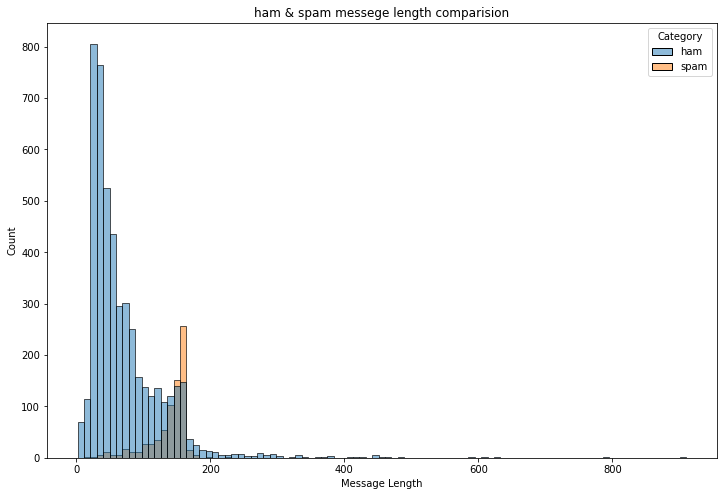

In [17]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [18]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:
 count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Message Length, dtype: float64
************************************
Spam Message Length Description:
 count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Message Length, dtype: float64


In [19]:
data.describe(include="all")

,Category,Message,Message Length
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,80.118808
std,NaN,NaN,59.690841
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,61.000000
75%,NaN,NaN,121.000000


In [20]:
data["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

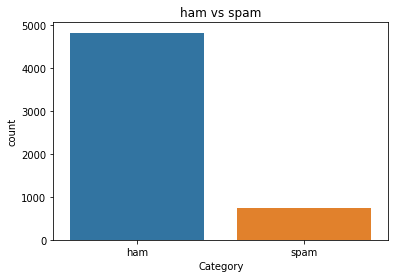

In [21]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [22]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.
Spam contains:13.41% of total data.


In [23]:
#compute the length of majority & minority class
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)

In [24]:
df.shape

(1494, 3)

In [25]:
df["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

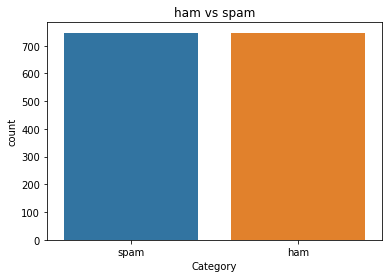

In [26]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

In [36]:
df.head()

,Category,Message,Message Length,Label
0,spam,22 days to kick off! For Euro2004 U will be ke...,140,1
1,ham,Raviyog Peripherals bhayandar east,34,0
2,spam,You are awarded a SiPix Digital Camera! call 0...,153,1
3,spam,RCT' THNQ Adrian for U text. Rgds Vatian,40,1
4,spam,"our mobile number has won å£5000, to claim cal...",100,1


In [6]:
stemmer=PorterStemmer()
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#declare empty list to store tokenized message
corpus=[]


#iterate through the df["Message"]
for message in ["Message"]:
    
    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)
    
    #convert every letters to its lowercase
    message=message.lower()
    
    #split the word into individual word list
    message=message.split()
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
 #perform stemming using PorterStemmer for all non-english-stopwords

    #join the word lists with the whitespace
message=" ".join(message)
    
    #append the message in corpus list
corpus.append(message)

In [14]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

In [26]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,confusion_matrix

In [28]:
ls

drive/  sample_data/


In [29]:
cd /content/drive/MyDrive/Assignment 4

/content/drive/MyDrive/Assignment 4


In [30]:
!unzip archive.zip

Archive:  archive.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spam.csv                


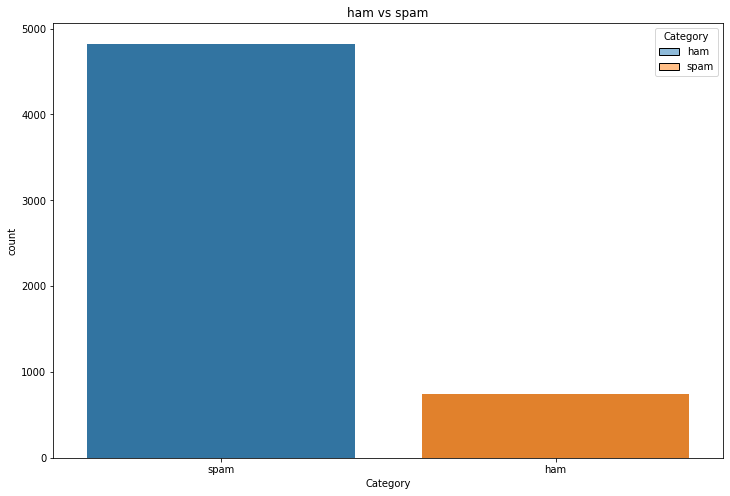

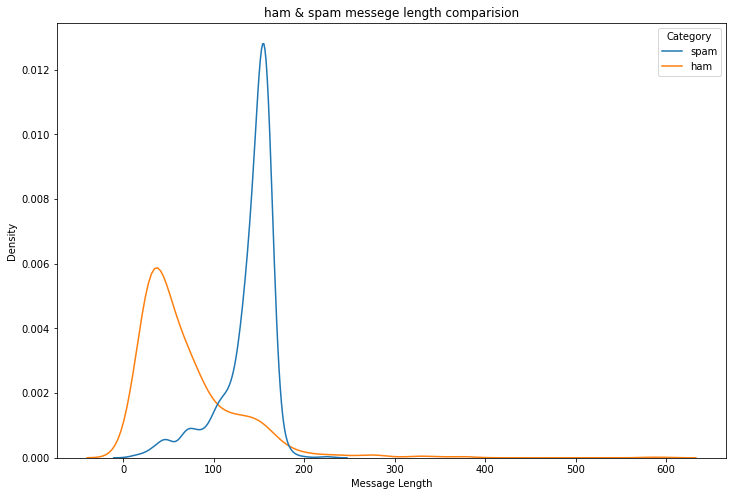

In [31]:


data=pd.read_csv("spam.csv",encoding="latin")
data=data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])
data=data.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)
data["Message Length"]=data["Message"].apply(len)
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]
#compute the length of majority & minority class
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]

#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

stemmer=PorterStemmer()
#declare empty list to store tokenized message
corpus=[]

#iterate through the df["Message"]
for message in df["Message"]:
    
    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)
    
    #convert every letters to its lowercase
    message=message.lower()
    
    #split the word into individual word list
    message=message.split()
    
    #perform stemming using PorterStemmer for all non-english-stopwords
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
            ]
    #join the word lists with the whitespace
    message=" ".join(message)
    
    #append the message in corpus list
    corpus.append(message)
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]
df_final=pd.concat([extract_features,target],axis=1)


In [32]:
df_final=pd.concat([extract_features,target],axis=1)

In [33]:
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Label
0,0,0,0,0,0,0,0,0,0,0,...,5699,4098,3236,8573,122,2840,6716,6397,6375,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2051,6841,6391,0
2,0,0,0,0,0,0,0,0,0,0,...,9153,529,7187,7145,6716,929,6716,1607,8084,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,5677,9534,6684,3975,6809,136,4720,0
4,0,0,0,0,0,0,0,0,0,0,...,3917,5743,5988,5652,9961,6003,3718,9585,9585,1


In [34]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [35]:
X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)
X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)
model=Sequential()
feature_num=100
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=feature_num,
        input_length=sentence_len
    )
)
model.add(
    LSTM(
    units=128
    )
)

model.add(
    Dense(
        units=1,
        activation="sigmoid"
    )
)
model.compile(
    optimizer=Adam(
    learning_rate=0.001
    ),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.fit(
    X_train,
    y_train,
    validation_data=(
        X_val,
        y_val
    ),
    epochs=10
)

Epoch 1/10
34/34 [==============================] - 16s 365ms/step - loss: 0.4845 - accuracy: 0.8024 - val_loss: 0.3319 - val_accuracy: 0.8377
Epoch 2/10
34/34 [==============================] - 14s 403ms/step - loss: 0.1702 - accuracy: 0.9490 - val_loss: 0.1645 - val_accuracy: 0.9424
Epoch 3/10
34/34 [==============================] - 12s 342ms/step - loss: 0.0655 - accuracy: 0.9824 - val_loss: 0.1225 - val_accuracy: 0.9476
Epoch 4/10
34/34 [==============================] - 12s 340ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 0.1262 - val_accuracy: 0.9476
Epoch 5/10
34/34 [==============================] - 13s 369ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 0.1173 - val_accuracy: 0.9476
Epoch 6/10
34/34 [==============================] - 12s 340ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.1454 - val_accuracy: 0.9424
Epoch 7/10
34/34 [==============================] - 11s 338ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.1374 - val_accuracy: 0.9424

In [36]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

8/8 [==============================] - 1s 92ms/step


In [37]:
score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:97.33%


array([[111,   4],
       [  2, 108]])

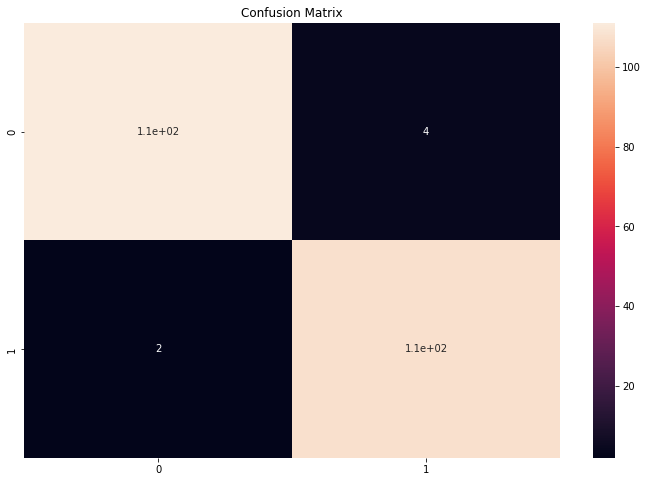

In [38]:
cm=confusion_matrix(y_test,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

In [40]:

import nltk
nltk.download('punkt')  #The function take model and message as parameter
def classify_message(model,message):
    
    #We will treat message as a paragraphs containing multiple sentences(lines)
    #we will extract individual lines
    for sentences in message:
        sentences=nltk.sent_tokenize(message)
        
        #Iterate over individual sentences
        for sentence in sentences:
            #replace all special characters
            words=re.sub("[^a-zA-Z]"," ",sentence)
            
            #perform word tokenization of all non-english-stopwords
            if words not in set(stopwords.words('english')):
                word=nltk.word_tokenize(words)
                word=" ".join(word)
    
    #perform one_hot on tokenized word            
    oneHot=[one_hot(word,n=vocab_size)]
    
    #create an embedded documnet using pad_sequences 
    #this can be fed to our model
    text=pad_sequences(oneHot,maxlen=sentence_len,padding="pre")
    
    #predict the text using model
    predict=model.predict(text)
    
    #if predict value is greater than 0.5 its a spam
    if predict>0.5:
        print("It is a spam")
    #else the message is not a spam    
    else:
        print("It is not a spam")
message1="I am having a bad day and I would like to have a break today"
message2="This is to inform you had won a lottery and the subscription will end in a week so call us."
classify_message(model,message1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1/1 [==============================] - 0s 27ms/step
It is not a spam


In [41]:
classify_message(model,message2)

1/1 [==============================] - 0s 28ms/step
It is a spam
